## Grid Study

In this example, we’ll walk through how to define a study config to compare retrieval performance using BM25 and vector search.

### Data Requirements

The most challenging part of any retrieval evaluation is often preparing a high-quality dataset. The Retrieval Optimizer is flexible—it supports a variety of formats—but to get started, your data should include three components: a **corpus**, a set of **queries**, and corresponding **qrels** (query relevance labels).

#### Corpus

The corpus is the collection of documents your search system will index. Each entry should include the core searchable text and can optionally include other fields like a title or metadata.

**General structure:**

```json
{
    "corpus_id": {
        "text": "text to be searched or vectorized",
        "title": "optional associated title"
    }
}
```

**Example:**

```json
{
    "MED-10": {
        "text": "Recent studies have suggested that statins, an established drug group in the prevention of cardiovascular mortality, could delay or prevent breast cancer recurrence...",
        "title": "Statin Use and Breast Cancer Survival: A Nationwide Cohort Study from Finland"
    }
}
```

#### Queries

These are the search inputs that will be run against the corpus to evaluate system performance.

**General structure:**

```json
{
    "query_id": "query text"
}
```

**Example:**

```json
{
    "PLAIN-2": "Do Cholesterol Statin Drugs Cause Breast Cancer?",
    "PLAIN-12": "Exploiting Autophagy to Live Longer"
}
```

#### Qrels

Qrels define which corpus entries are considered relevant for each query. These are used to compute metrics like precision, recall, F1, and NDCG.

**General structure:**

```json
{
    "query_id": {
        "corpus_id": "relevance score"
    }
}
```

**Example:**

```json
{
    "PLAIN-2": {
        "MED-2427": 2,
        "MED-2440": 1,
        "MED-2434": 1
    },
    "PLAIN-12": {
        "MED-2513": 2,
        "MED-5237": 2
    }
}
```

*Note:* For most basic metrics, a binary relevance label (e.g., 0 or 1) is sufficient. Graded scores (e.g., 1 or 2) are used in metrics that account for ranking quality like NDCG.


## Installation

In [ ]:
%pip install redis-retrieval-optimizer

## Check version

> Note: for advanced hybrid functionality you will need `redisvl>=0.13.0`, `redis-retrieval-optimizer>=0.4.3`, and redis database version >=8.4.0. 

In [1]:
import redis_retrieval_optimizer

redis_retrieval_optimizer.__version__

'0.4.3'

In [2]:
import redisvl
redisvl.__version__

'0.13.2'

### Sourcing Data

To make it easier to get started, this example uses datasets from the excellent [BEIR project](https://github.com/beir-cellar/beir), a benchmark suite for information retrieval. The Retrieval Optimizer includes helpers for working with BEIR datasets out of the box.

For custom or domain-specific use cases, you can create your own dataset following the same format. Even a small sample of labeled queries and relevant documents can be a valuable starting point—and you can optionally use a language model to expand these examples for broader testing.

In [5]:
from redis_retrieval_optimizer.corpus_processors import eval_beir

# check the link above for different datasets to try
beir_dataset_name = "nfcorpus"
data_folder = "data"

# Load sample data
corpus, queries, qrels = eval_beir.get_beir_dataset(beir_dataset_name)

100%|██████████| 3633/3633 [00:00<00:00, 142450.28it/s]


Now that we have our data we will save it locally to the gitignored `data/` folder

In [3]:
import os

os.makedirs(data_folder, exist_ok=True)

In [4]:
import json

with open(f"data/{beir_dataset_name}_corpus.json", "w") as f:
    json.dump(corpus, f)

with open(f"data/{beir_dataset_name}_queries.json", "w") as f:
    json.dump(queries, f)

with open(f"data/{beir_dataset_name}_qrels.json", "w") as f:
    json.dump(qrels, f)

# Define a study config

To set the parameters of our study we need to define a study configuration file. In this directory there is a sample config which looks like the following:

In [1]:
import yaml

with open("grid_study_config.yaml", "r") as f:
    study_config = yaml.safe_load(f)

study_config

{'corpus': 'data/nfcorpus_corpus.json',
 'queries': 'data/nfcorpus_queries.json',
 'qrels': 'data/nfcorpus_qrels.json',
 'index_settings': {'name': 'optimize',
  'vector_field_name': 'vector',
  'text_field_name': 'text',
  'from_existing': False,
  'additional_fields': [{'name': 'title', 'type': 'text'}],
  'vector_dim': 384},
 'embedding_models': [{'type': 'hf',
   'model': 'sentence-transformers/all-MiniLM-L6-v2',
   'dim': 384,
   'embedding_cache_name': 'vec-cache'}],
 'search_methods': ['rrf_8_4',
  'hybrid_8_4',
  'bm25',
  'vector',
  'hybrid',
  'rerank',
  'weighted_rrf'],
 'vector_data_types': ['float16', 'float32']}

## Available search methods

The available search methods are defined in `redis_retrieval_optimizer.search_methods.__init__` and you can see the active `SEARCH_METHOD_MAP` which maps the string input in search_method to the corresponding function.

You can define your own SEARCH_METHOD_MAP and pass it in to define your custom retrieval logic.

# Run a study

Now we can simply pass in the path to our study_config file and our pre-defined corpus processor function and let the retrieval optimizer do the rest. 

In [2]:
import os
from redis_retrieval_optimizer.grid_study import run_grid_study
from redis_retrieval_optimizer.corpus_processors import eval_beir
from dotenv import load_dotenv

# load environment variables containing necessary credentials
load_dotenv()

redis_url = os.environ.get("REDIS_URL", "redis://localhost:6379/0")

metrics = run_grid_study(
    config_path="grid_study_config.yaml",
    redis_url=redis_url,
    corpus_processor=eval_beir.process_corpus
)

/Users/robert.shelton/Documents/redis-retrieval-optimizer/.venv/lib/python3.13/site-packages/beir/util.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/Users/robert.shelton/Documents/redis-retrieval-optimizer/.venv/lib/python3.13/site-packages/redisvl/query/hybrid.py:136: UserWarning: HybridPostProcessingConfig is an experimental and may change or be removed in future versions.
  self.postprocessing_config = HybridPostProcessingConfig()
/Users/robert.shelton/Documents/redis-retrieval-optimizer/.venv/lib/python3.13/site-packages/redisvl/query/hybrid.py:247: UserWarning: HybridSearchQuery is an experimental and may change or be removed in future versions.
  search_query = HybridSearchQuery(
/Users/robert.shelton/Documents/redis-retrieval-optimizer/.venv/lib/python3.13/site-packages/redisvl/query/hybrid.py:288: UserWarning: HybridVsimQuery is an experimenta

In [3]:
metrics[["search_method", "model", "vector_data_type", "avg_query_time", "f1", "recall", "precision"]].sort_values(by="f1", ascending=False)

,search_method,model,vector_data_type,avg_query_time,f1,recall,precision
5,rerank,sentence-transformers/all-MiniLM-L6-v2,float16,0.208733,0.135851,0.143596,0.303922
12,rerank,sentence-transformers/all-MiniLM-L6-v2,float32,0.194852,0.135851,0.143596,0.303922
0,rrf_8_4,sentence-transformers/all-MiniLM-L6-v2,float16,0.001439,0.133953,0.167163,0.240557
7,rrf_8_4,sentence-transformers/all-MiniLM-L6-v2,float32,0.001472,0.133953,0.167163,0.240557
2,bm25,sentence-transformers/all-MiniLM-L6-v2,float16,0.000722,0.129479,0.122123,0.312332
9,bm25,sentence-transformers/all-MiniLM-L6-v2,float32,0.000693,0.129479,0.122123,0.312332
6,weighted_rrf,sentence-transformers/all-MiniLM-L6-v2,float16,0.002330,0.127979,0.136638,0.288958
13,weighted_rrf,sentence-transformers/all-MiniLM-L6-v2,float32,0.002816,0.127979,0.136638,0.288958
3,vector,sentence-transformers/all-MiniLM-L6-v2,float16,0.000665,0.122711,0.126754,0.284314
4,hybrid,sentence-transformers/all-MiniLM-L6-v2,float16,0.000961,0.122711,0.126754,0.284314


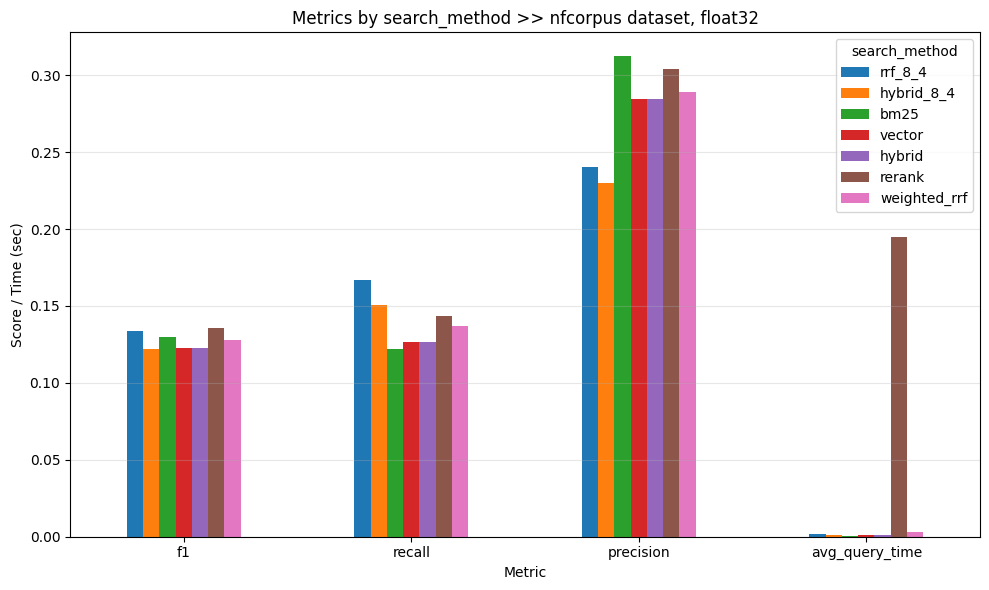

In [6]:
import matplotlib.pyplot as plt

# Filter and shape the data
subset = metrics[metrics["vector_data_type"] == "float32"].copy()
subset = subset.set_index("search_method")[["f1", "recall", "precision", "avg_query_time"]]

# Transpose so metrics are rows (x-axis groups), methods are columns (bars)
ax = subset.T.plot(kind="bar", figsize=(10, 6))

ax.set_xlabel("Metric")
ax.set_ylabel("Score / Time (sec)")

ax.set_title(f"Metrics by search_method >> {beir_dataset_name} dataset, float32")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()